In [1]:
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set up

In [2]:
# set up auto load
%load_ext autoreload
%autoreload 2

In [3]:
from load_data import *
from model import *
plt.rcParams['font.family'] = 'serif'
sns.set_style("darkgrid")

In [4]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print('PyTorch CUDA is available?', torch.cuda.is_available())

PyTorch CUDA is available? True


# Get the training set
The training set is a combination of a list of tickers, see load_data.py for details. The training set must be shuffled (default) so that it can introduce randomness to data and can train the model better. look_back is a hyper-param and adjusting the look_back value may also need to adjust the learning rate.

In [25]:
train_ticker_strings = ["AAPL", "AMZN", "CAT", "GOOG", "HSBC", "KO", "JPM", "PCG", "ABB", "BAC", "BP"]
look_back = 60
train_data_loader = get_data_loader(TransformerMultiFeaturesDataset, train_ticker_strings, look_back=look_back)
print("train data size (in batches):", len(train_data_loader))

train data size (in batches): 412


# Create the model.
Hyper-params can be adjusted.

In [26]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 1000
lr = 0.001
hist = np.zeros(num_epochs)

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 4])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


# Train the model

In [27]:

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    total_loss = 0
    y_train_preds = []
    for X_train, y_train in train_data_loader:

        # Forward pass
        y_train_pred = model(X_train)
        y_train_preds.extend(y_train_pred)

        loss = loss_fn(y_train_pred, y_train.to(device))

        total_loss += loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", total_loss)


Epoch  10 MSE:  19.722135508432984
Epoch  20 MSE:  19.564536206424236
Epoch  30 MSE:  19.431462235748768
Epoch  40 MSE:  19.29284350387752
Epoch  50 MSE:  19.15050472225994
Epoch  60 MSE:  18.790766140446067
Epoch  70 MSE:  18.20947667211294
Epoch  80 MSE:  17.30079166032374
Epoch  90 MSE:  16.14726020488888
Epoch  100 MSE:  14.935246736742556
Epoch  110 MSE:  13.825393792241812
Epoch  120 MSE:  12.72127079591155
Epoch  130 MSE:  11.532860011793673
Epoch  140 MSE:  10.61974427755922
Epoch  150 MSE:  9.7147954730317
Epoch  160 MSE:  8.815038722008467
Epoch  170 MSE:  8.1834133034572
Epoch  180 MSE:  7.724513947963715
Epoch  190 MSE:  7.1591471820138395
Epoch  200 MSE:  6.774699946865439
Epoch  210 MSE:  6.2805734006688
Epoch  220 MSE:  6.606545649468899
Epoch  230 MSE:  5.781242489116266
Epoch  240 MSE:  5.319337644614279
Epoch  250 MSE:  5.1310322971548885
Epoch  260 MSE:  5.089131991844624
Epoch  270 MSE:  4.59323229175061
Epoch  280 MSE:  4.441684917081147
Epoch  290 MSE:  4.16311190

# Plot the learning curve

Text(0.5, 1.0, 'Loss')

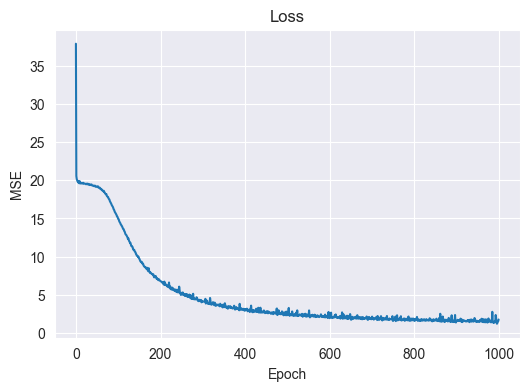

In [28]:
figure, axes = plt.subplots(figsize=(6, 4))
plt.plot(range(num_epochs), hist)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Loss")

# Prediction
Change the ticker name in test_ticker_string and run the rest of the cells to make a prediction on the given ticker. It can only predict one ticker at a time.

In [31]:
test_ticker_string = ['MSFT']
test_data_loader = get_data_loader(TransformerMultiFeaturesDataset, test_ticker_string, look_back=look_back, shuffle=False, train=False)
predicted_ticker = test_ticker_string[0]
print("test data size (in batches):", len(test_data_loader))

test data size (in batches): 38


In [32]:
# make predictions
y_tests = []
y_test_preds = []
for X_test, y_test in test_data_loader:
    X_test = X_test.to(device)
    y_tests.extend(y_test)
    pred = model(X_test)
    pred = pred.detach().cpu()
    y_test_preds.extend(pred)

# y_tests = test_data_loader.dataset.df['Adj Close'][look_back:].values
y_tests = torch.stack(y_tests).cpu().detach().numpy()
y_test_preds = torch.stack(y_test_preds).cpu().detach().numpy()

# calculate root mean squared error
testScore = (mean_squared_error(y_tests, y_test_preds))
print('Test Score: %.5f MSE' % (testScore))

y_tests = test_data_loader.dataset.df['Adj Close']
y_tests = np.array(y_tests)
# N, 1 -> N, 1, D
y_test_preds = np.expand_dims(y_test_preds, axis=2).repeat(input_dim, axis=2)
# N, 1
y_test_preds = test_data_loader.dataset.invert_transform(y_test_preds)
test_price_score = np.sqrt(mean_squared_error(y_tests, y_test_preds))
print('Test Price Score: %.2f RMSE' % (test_price_score))

Test Score: 0.09809 MSE
Test Price Score: 0.85 RMSE


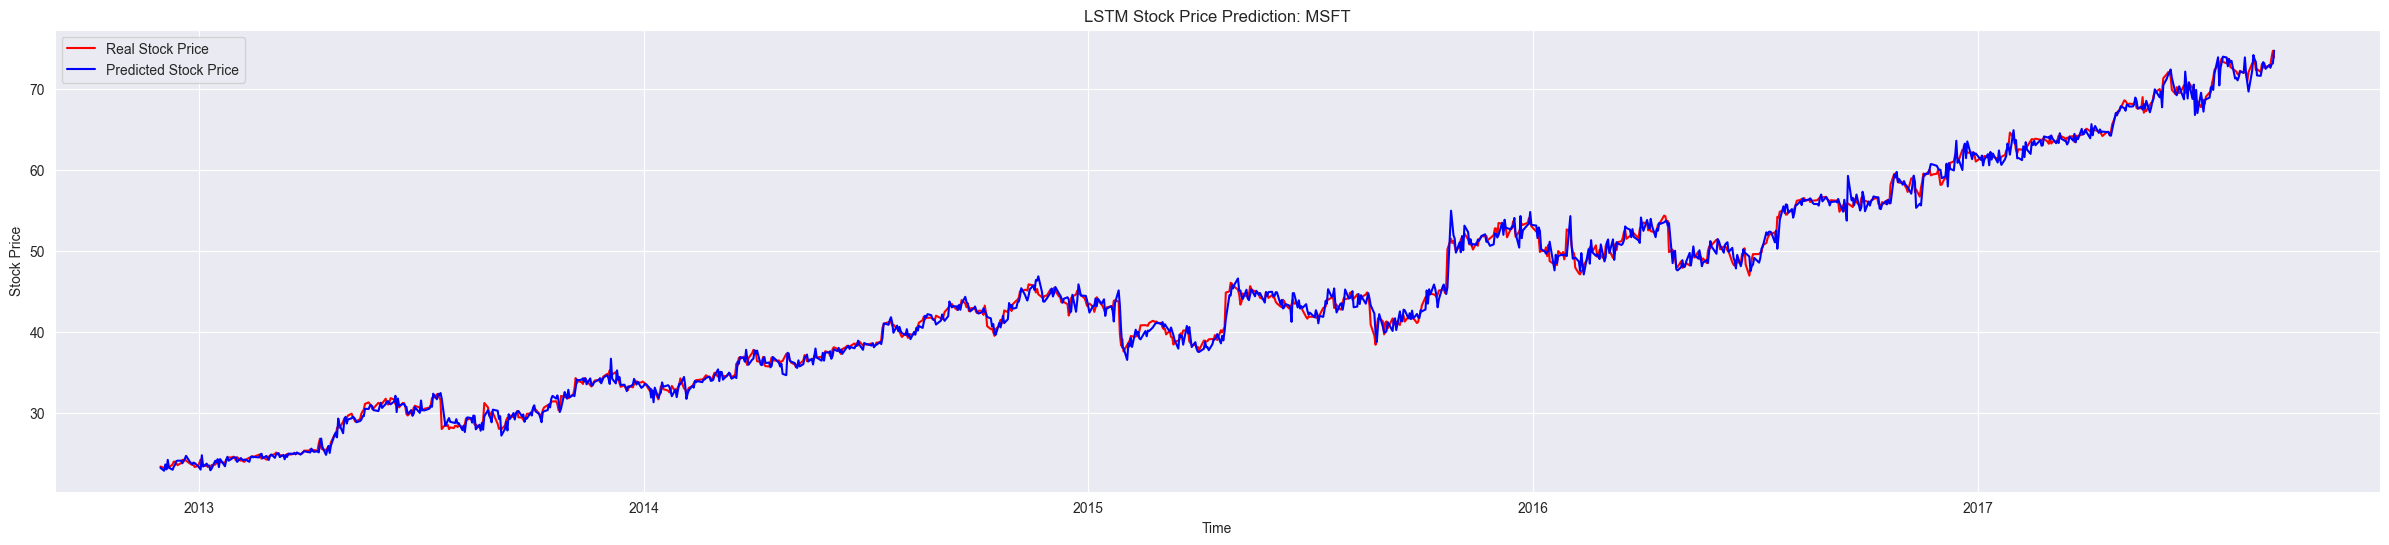

In [33]:
# Visualising the results
figure, axes = plt.subplots(figsize=(30, 6))
axes.xaxis_date()

df = test_data_loader.dataset.df

axes.plot(df.index, y_tests, color = 'red', label = 'Real Stock Price')
axes.plot(df.index, y_test_preds[:,0], color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title(f'LSTM Stock Price Prediction: {predicted_ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig(f'./plots/lstm_baseline_pred_{predicted_ticker}.png')
plt.show()

In [34]:
correct_pred = 0
incorrect_pred = 0
for i in range(1, len(y_tests)):
    if (y_tests[i] - y_tests[i-1]) * (y_test_preds[i] - y_test_preds[i-1]) > 0:
        correct_pred += 1
    else:
        incorrect_pred += 1

print("Accuracy of predicting rise/drop: ", correct_pred / (correct_pred + incorrect_pred))

Accuracy of predicting rise/drop:  0.47869674185463656


In [36]:
save_path = './models/lstm_multifeatures_model.pth'

# Save the model to file
torch.save(model.state_dict(), save_path)